<a href="https://colab.research.google.com/github/pjchickey/RACOON/blob/Angel/Algorithm/RACOON_Tflite_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [15]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
import pandas as pd

pd.set_option("display.precision", 8)

In [18]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.11.0
Eager mode:  True
GPU is available


# Transfer Learning

In [19]:
data_root = '/content/drive/MyDrive/Images-resized'

In [20]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 198 images belonging to 2 classes.
Found 797 images belonging to 2 classes.


In [21]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [22]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Recycleable' 'Trash']


In [23]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [25]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)


hist = model.fit(train_generator, 
                 epochs=50,
                 verbose=1,
                 steps_per_epoch=len(train_generator),
                 validation_data=valid_generator,
                 validation_steps=len(valid_generator),
                 callbacks=[EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          verbose=1,
                                          patience=10,
                                          restore_best_weights=True)]).history

Train for 25 steps, validate for 7 steps
Epoch 1/50
25/25 [==============================] - 81s 3s/step - loss: 0.9406 - acc: 0.5910 - val_loss: 0.7074 - val_acc: 0.5808
Epoch 2/50
25/25 [==============================] - 13s 521ms/step - loss: 0.6035 - acc: 0.7202 - val_loss: 0.6379 - val_acc: 0.6414
Epoch 3/50
25/25 [==============================] - 13s 511ms/step - loss: 0.5066 - acc: 0.7578 - val_loss: 0.5946 - val_acc: 0.6818
Epoch 4/50
25/25 [==============================] - 13s 513ms/step - loss: 0.4771 - acc: 0.7905 - val_loss: 0.5696 - val_acc: 0.6970
Epoch 5/50
25/25 [==============================] - 13s 507ms/step - loss: 0.4121 - acc: 0.8130 - val_loss: 0.5746 - val_acc: 0.6970
Epoch 6/50
25/25 [==============================] - 13s 507ms/step - loss: 0.4162 - acc: 0.8080 - val_loss: 0.5590 - val_acc: 0.7121
Epoch 7/50
25/25 [==============================] - 13s 510ms/step - loss: 0.3714 - acc: 0.8381 - val_loss: 0.5575 - val_acc: 0.7071
Epoch 8/50
25/25 [=============

In [26]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

7/7 [==============================] - 3s 376ms/step - loss: 0.5188 - acc: 0.7525


In [27]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.52
Final accuracy: 75.25%


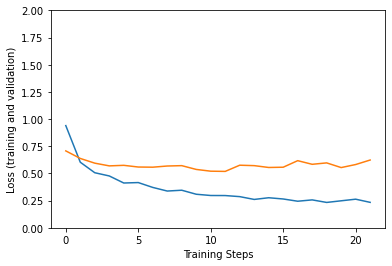

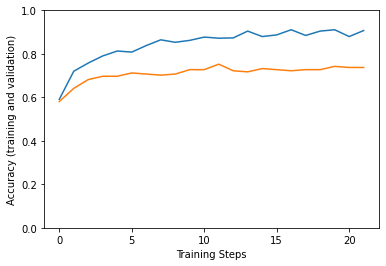

In [28]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

# Save and load model

In [29]:
RACOON_SAVED_MODEL = "saved_models/racoon"
tf.saved_model.save(model, RACOON_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models/racoon/assets


INFO:tensorflow:Assets written to: saved_models/racoon/assets


In [30]:
# Load SavedModel

racoon_model = hub.load(RACOON_SAVED_MODEL)
print(racoon_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f11a8e12750>


In [31]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [32]:
tf_model_predictions = racoon_model(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [33]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Recycleable,Trash
0,0.80155385,0.19844615
1,0.82275820,0.17724183
2,0.40179303,0.59820700
3,0.96075827,0.03924174
4,0.94151694,0.05848302


In [34]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

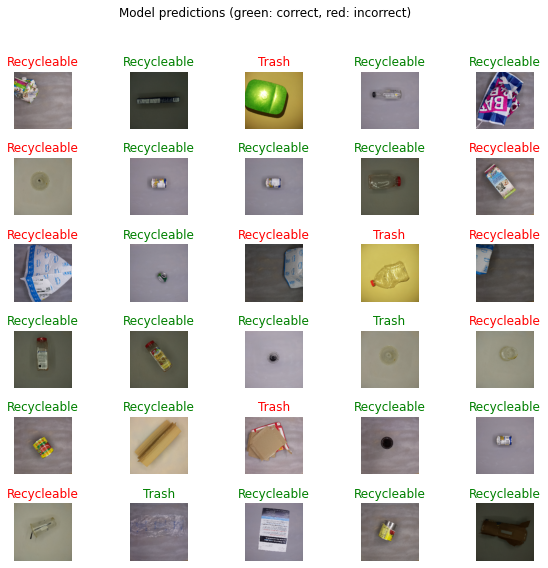

In [35]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Convert model to TFLite

In [36]:
!mkdir "tflite_models"

In [37]:
TFLITE_MODEL = "tflite_models/racoon.tflite"

In [38]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : racoon_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 8.5M
-rw-r--r-- 1 root root 8.5M Apr 11 17:27 racoon.tflite


In [39]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 2]
type: <class 'numpy.float32'>


In [40]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 13))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  2]
type: <class 'numpy.float32'>


In [41]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 2)


In [42]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Recycleable,Trash
0,0.80155283,0.19844712
1,0.82276076,0.17723921
2,0.40179259,0.59820735
3,0.96075803,0.03924199
4,0.94151694,0.05848309


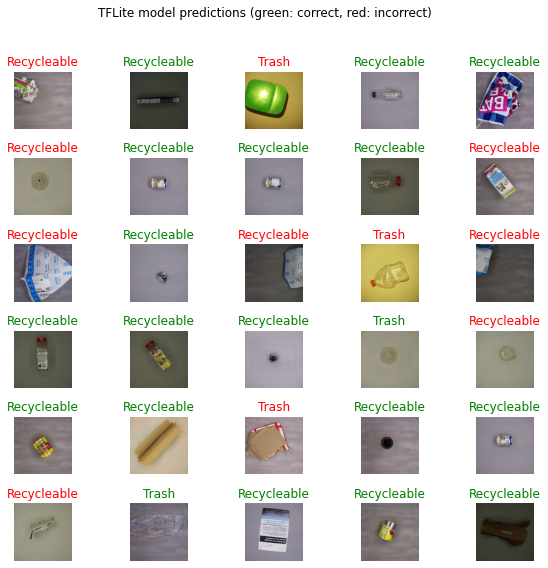

In [43]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")